In [1]:
import random
import time
import gym
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import urllib.request

from torch.autograd import Variable
from collections import OrderedDict, deque
from tqdm import tqdm
from operator import add
from datetime import datetime

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

In [2]:
!mkdir models

In [3]:
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python3 -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                 36  OK 
Extracting  ROMS.zip                                                    7 99  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bom

In [4]:
class Actor_Network(nn.Module):

    def __init__(self, input_size, output_size, learning_rate, path = 'models/'):
        super(Actor_Network, self).__init__()
        self.path = path
 
        # self.linear_model = nn.Sequential(OrderedDict([
        #     ('conv1', nn.Conv2d(4, 32, kernel_size=8, stride=4)),
        #     ('relu1', nn.ReLU()),
        #     ('conv2', nn.Conv2d(32, 64, 4, 2)),
        #     ('relu2', nn.ReLU()),
        #     ('conv3', nn.Conv2d(64, 64, 3, 1)),
        #     ('relu3', nn.ReLU()),
        #     ('flatten1', nn.Flatten()),
        #     ('dense1', nn.Linear(7*7*64, 512)),
        #     ('relu4', nn.ReLU()),
        #     ('dense2', nn.Linear(512, output_size))]
        # ))
        self.linear_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(4, 16, kernel_size=8, stride=4)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(16, 32, 4, 2)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(32, 32, 3, 1)),
            ('relu3', nn.ReLU()),
            ('flatten1', nn.Flatten()),
            ('dense1', nn.Linear(7*7*32, 256)),
            ('relu4', nn.ReLU()),
            ('dense2', nn.Linear(256, output_size))]
        ))
        self.optimizer = optim.AdamW(self.parameters(),lr=lr)
        
    def forward(self, x):
        x = self.linear_model(x)
        output = F.softmax(x, dim = 1)
        return output
        
    def save_model(self,filename='a2c_actor_breakout.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_actor_breakout.pth'):
        self.load_state_dict(torch.load(self.path+filename))


In [5]:
class Critic_Network(nn.Module):

    def __init__(self, input_size, output_size, learning_rate, path = 'models/'):
        super(Critic_Network, self).__init__()
        self.path = path

        self.linear_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(4, 16, kernel_size=8, stride=4)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(16, 32, 4, 2)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(32, 32, 3, 1)),
            ('relu3', nn.ReLU()),
            ('flatten1', nn.Flatten()),
            ('dense1', nn.Linear(7*7*32, 256)),
            ('relu4', nn.ReLU()),
            ('dense2', nn.Linear(256, output_size))]
        ))
        self.optimizer = optim.AdamW(self.parameters(),lr=lr)
        
    def forward(self, x):
        x = self.linear_model(x)
        return x
        
    def save_model(self,filename='a2c_critic_breakout.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_critic_breakout.pth'):
        self.load_state_dict(torch.load(self.path+filename))

In [6]:
class DQNagent:
    '''
    DQNagent is a class that defines the agent.
    '''
    def __init__(self, state_size, action_size, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        # self.epsilon = epsilon
        # self.epsilon_decay = epsilon_decay
        # self.epsilon_min = 0.01
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.actor_network = Actor_Network(self.state_size, self.action_size, self.learning_rate).to(self.device)
        self.critic_network = Critic_Network(self.state_size, 1, self.learning_rate).to(self.device)
        
    def get_action(self, observation):
        '''
        This function defines epsilon greedy behavior of the agent.
        '''
        probs = self.actor_network.forward(observation)
        actions_probabilities = torch.distributions.Categorical(probs)
        action = actions_probabilities.sample()
        log_probability = actions_probabilities.log_prob(action)
        return action.cpu().detach().numpy()[0], log_probability
    
    def append_memory(self, state, action, reward, next_state, done, log_probability):
        '''
        Save each experience in the replay memory
        '''
        self.memory.append((state, action, reward, next_state, done, log_probability))
    
    # def update_target_policy(self):
    #     '''
    #     Update the target network parameters based on the policy network parameters
    #     '''
    #     self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def update_epsilon(self):
        '''
        Perform epsilon decay
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    def preprocess_state(self, state):
        img = state[34:-16, :, :]
        resize = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((84, 84)),
                    T.ToTensor()
                ])
        img = resize(img)
        return img.to(self.device)

    def train_model(self):
        '''
        Train the agent
        '''
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = torch.tensor([]).float().to(self.device)
            actions = list()
            rewards = list()
            next_states = torch.tensor([]).float().to(self.device)
            dones = list()
            log_probability = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean, log_prob = mini_batch[i]
                current_state = torch.cat((current_state, state)).float().to(self.device)
                actions.append(action)
                rewards.append(reward)
                next_states = torch.cat((next_states, next_state)).float().to(self.device)
                dones.append(done_boolean)
                log_probability.append(log_prob)
            
            # Convert each list to torch tensors
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)
            log_probability = torch.stack(log_probability, dim=0).to(self.device)

            current_state_value = self.critic_network.forward(current_state)
            next_state_value = self.critic_network.forward(next_states)
            
            current_state_value = torch.squeeze(current_state_value)
            next_state_value = torch.squeeze(next_state_value)
            
            delta = list()
            for index in range(len(current_state_value)):
                if dones[index]:
                    delta.append(rewards[index] - current_state_value[index])
                else:
                    delta.append(rewards[index] + self.discount_factor * next_state_value[index] - current_state_value[index])
            delta = torch.stack(delta, dim=0)
            
            critic_loss = 0
            for i in delta:
                critic_loss += (i ** 2)
            critic_loss = critic_loss.mean()

            self.critic_network.optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_network.optimizer.step()

            actor_loss = []
            for i in range(len(current_state_value)):
                actor_loss.append(-log_probability * delta[i].detach())
            actor_loss = torch.stack(actor_loss, dim=0)
            actor_loss = torch.mean(actor_loss)
            var_actor_loss = Variable(actor_loss.data, requires_grad=True)
            self.actor_network.optimizer.zero_grad()
            var_actor_loss.backward(retain_graph=True)
            self.actor_network.optimizer.step()
    
    def test_model(self, agent, env, episodes, perform_render=False):
        '''
        Test the agent behavior after it has been trained
        Agent follows only the greedy policy
        '''
        
        total_reward_arr = list()
        timesteps = 0
        
        for episode in tqdm(range(episodes)):
            current_state = env.reset()

            obs, _, _, _ = env.step(1)
            current_state = agent.preprocess_state(obs)
            current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0)

            dead = False
            done = False
            total_reward = 0
            agent_lives = 5
            
            while not done:
                action, log_probability = self.get_action(current_state)
                
                next_state, reward, done, info = env.step(action)
                next_state = agent.preprocess_state(next_state) # 84-84
                next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84

                if agent_lives > info['ale.lives']:
                    dead = True
                    agent_lives = info['ale.lives']

                if dead:
                    obs, _, _, _ = env.step(1)
                    obs = agent.preprocess_state(obs)
                    current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
                    dead = False
                else:
                    current_state = next_state_history

                total_reward += reward
                
                # Render only for the final episode
                if perform_render and episodes-1 == episode:
                    env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr0

In [7]:
def plot_graphs(title, total_reward, epsilon_decay, cumulative_reward, avg_timestep, episodes):
    '''
    This functions plots the graphs for rewards, epsilon, success, failure and avergae timesteps
    
    Success is defined when the agent has reached the goal state
    Failure is defined when the agent meets the monster or falls in the pit
    '''
    
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85, hspace=0.2, wspace=0.2)
    
    axs[0].plot(avg_timestep)
    axs[0].set_title('Average timesteps per 50 episodes')
    axs[0].set_xticks(np.arange(len(avg_timestep)))
    axs[0].set_xticklabels(list(range(0,episodes+1,50))[1:], rotation=90)
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Timesteps')
    
    axs[1].plot(total_reward)
    axs[1].set_title('Total Reward per episode')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Rewards')
    
    plt.show()

In [8]:
# Parameters
env = gym.make('BreakoutDeterministic-v4')
state_size = env.observation_space.shape
action_size = env.action_space.n

batch_size = 32
lr = 0.0001
discount_factor = 0.99
update_frequency = 5

memory_len = 100000
episodes = 50000
test_episodes = 100
perform_render = False

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

total_reward_arr = list() # Store total reward per episode values
cumulative_reward_arr = list() # Store cumulative reward
epsilon_decay_arr = [] # Store each epsilon value after decay
timestep_arr = list() # Store the timestep per episode
avg_timestep_arr = list() # Store average timestep every 20 episodes
test_total_reward_arr = list()

agent = DQNagent(state_size, action_size, batch_size, lr, discount_factor, memory_len)
success_count = 0
failure_count = 0
train_timestep = 12

for episode in tqdm(range(episodes)):
    done = False
    dead = False
    # perform_fire = True

    total_reward = 0
    timesteps = 0
    agent_lives = 5
    env = gym.make('BreakoutDeterministic-v4')
    current_state = env.reset() 

    obs, _, _, _ = env.step(1)
    current_state = agent.preprocess_state(obs)
    current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0) # 1-4-84-84
    # print(f'\nEpisode: {episode}, Agent Lives: {agent_lives}')
    
    while not done:        
        action, log_probability = agent.get_action(current_state)
        # print(type(log_probability))
        next_state, reward, done, info = env.step(action)
        # print(f"Lives: {info['ale.lives']}")
        next_state = agent.preprocess_state(next_state) # 84-84
        next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84
        
        agent.append_memory(current_state, action, reward, next_state_history, done, log_probability)

        if agent_lives > info['ale.lives']:
            dead = True
            agent_lives = info['ale.lives']

        if timesteps % train_timestep == 0:
            agent.train_model()

        total_reward += reward
        timesteps += 1
        
        if dead:
            obs, _, _, _ = env.step(1)
            obs = agent.preprocess_state(obs)
            current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
            dead = False
        else:
            current_state = next_state_history

    # epsilon = agent.update_epsilon()
    # epsilon_decay_arr.append(epsilon)

    timestep_arr.append(timesteps)

    # Calculate average timesteps for 50 timesteps
    if done and (episode+1) % 50 == 0:
        avg_timestep_arr.append(np.average(timestep_arr))
        timestep_arr.clear()

    total_reward_arr.append(total_reward)

    if np.mean(total_reward_arr[-20:]) > 200:
        break
    
    if total_reward > 200:
        with open("200_log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")
        agent.actor_network.save_model(f"actor_episode_{episode}.pth")
        agent.critic_network.save_model(f"critic_episode_{episode}.pth")

    if episode > 12000:
        with open("reward_check.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")

    if episode % 100 == 0:
        with open("log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Total Reward: {total_reward}\n")

# Save the model weights
# agent.save_model("DQN_breakout_weights.pth")
agent.actor_network.save_model()
agent.critic_network.save_model()
    
# Test the agent
# test_total_reward_arr = agent.test_model(agent, env, test_episodes, perform_render=perform_render)

  1%|          | 595/50000 [07:51<10:52:24,  1.26it/s]


RuntimeError: ignored

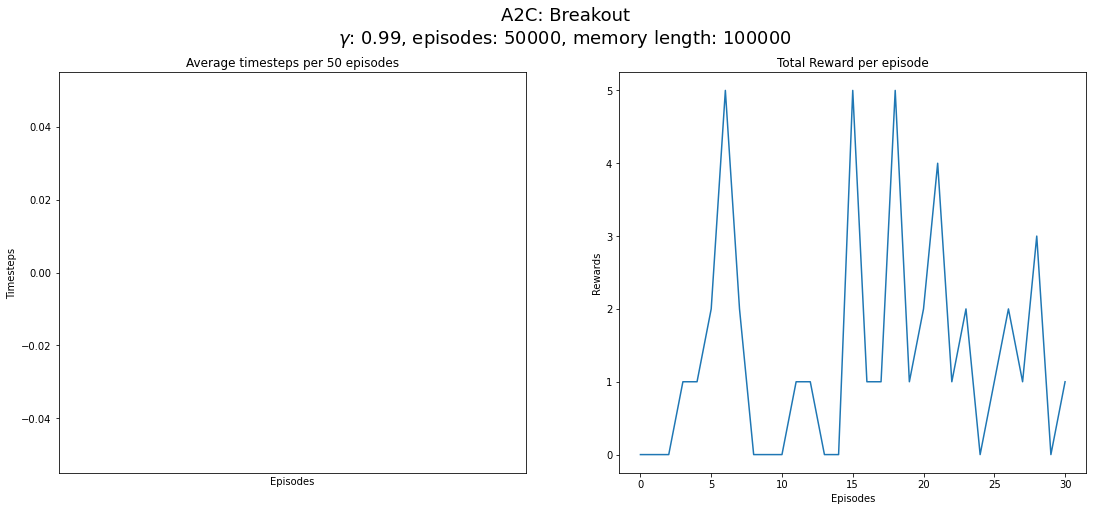

In [ ]:
# Plot graphs
title = 'A2C: Breakout\n' + r'$\gamma$: {}, episodes: {}, memory length: {}'.format(discount_factor, episodes, memory_len)

plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

In [ ]:
test_total_reward_arr1 = agent.test_model(agent, env, test_episodes, perform_render=perform_render)

  0%|          | 0/100 [00:00<?, ?it/s]

2
1
2
1
0
1
3
2
3
2
1
1
2
2
3
0
1
0
3
2
2
1
1
1
3
0
3
1
1
0
2
1
1
2
3
1
2
2
3
1
2
0
1
3
2
1
2
2
1
3
3
0
1
3
2
3
0
2
0
3
3
3
2
3
2
0
2
1
3
2
2
1
0
0
2
0
2
2
3
1
3
0
1
3
0
3
3
1
1
0
1
2
3
3
1
2
1
2
2
0
0
3
1
3
1
0
1
1
3
2
0
0
1
3
3
3
2
3
2
0
0
2
0
1
2
2
0
2
3
3
2
0
2
3
3
2
3
3
3
3
1
2
1
2
0
2
0
2
1


  1%|          | 1/100 [00:02<03:50,  2.33s/it]

3
3
1
1
2
2
1
2
2
3
2
2
0
0
2
1
3
3
0
3
2
3
0
2
0
1
0
2
3
3
1
2
3
2
0
3
0
1
3
0
0
1
0
1
2
2
0
3
2
1
2
0
0
3
0
0
1
2
1
1
3
2
1
2
1
3
0
3
1
2
0
0
3
3
1
2
2
2
2
1
3
1
1
0
1
0
1
3
1
1
1
3
1
0
1
0
0
2
2
3
1
3
2
3
3
2
1
1
1
1
3
3
3
1
1
1
0
2
1
2
1
3
2


  2%|▏         | 2/100 [00:03<03:08,  1.92s/it]

1
3
3
3
3
3
3
0
0
2
3
3
0
2
2
3
1
2
0
0
2
1
1
2
0
0
2
2
3
1
1
0
1
1
3
1
0
1
1
0
0
3
2
3
1
2
0
0
0
3
0
3
3
2
3
1
0
3
2
2
3
3
2
3
2
1
1
2
1
0
3
2
2
0
2
3
0
0
2
2
0
0
3
2
0
2
1
0
2
1
0
1
2
3
3
2
1
2
0
3
0
1
2
0
1
2
2
0
1
2
1
2
1
3
3
3
1
0
3
2
2
2
1
2
1
3
1
3
1
1
3
2
1
1
2
3
1
2
3
2
0
1
0
0
3
2
3
1
0
2
3
0
3
2
0
1
1
1
3
0
2
0
0
0
1
0
3
1
3
2
0
2
3
0
2
0
3
1
2
2
1
3
1
3
1
0
2
0
2
0
2
3
1
3
2
0
0
1
1
3
2
3
2
3
3
0
2
1
0
1
0
3
2
0
1
1
3
0
3
3
1
1
0
0
0
2
2
0
1
3
2
0
3
2
1
1
1
3
3
1
0
3
3
3
2
2
3
0
2
0
1


  3%|▎         | 3/100 [00:07<04:07,  2.55s/it]

2
0
2
1
3
3
3
2
1
0
1
2
1
0
0
0
1
1
0
2
3
3
3
3
1
2
1
1
2
2
0
2
3
2
0
0
0
2
3
0
3
2
2
3
2
0
3
2
1
3
1
1
3
2
0
1
1
3
0
1
0
2
0
3
0
3
2
1
3
2
2
0
1
2
2
3
1
2
2
2
1
2
1
1
1
2
2
2
2
2
0
1
2
1
0
0
1
3
2
3
2
1
0
1
3
0
0
2
3
1
0
1
1
1
0
1
3


  4%|▍         | 4/100 [00:09<03:34,  2.23s/it]

1
1
3
2
2
0
0
2
3
0
1
0
1
0
0
3
3
3
0
0
3
1
2
2
2
2
2
3
2
1
1
0
3
0
0
0
3
2
3
1
3
0
1
0
2
3
1
3
1
3
2
1
1
3
3
2
1
1
1
0
0
1
3
1
0
2
3
0
1
3
0
1
3
2
2
1
0
2
1
1
3
0
0
1
0
1
2
1
2
1
0
3
0
1
2
3
3
3
2
3
3
1
2
1
1
2
1
3
0
0
2
0
2
3
1
0
0
2
1
0
1
2
0
1
0
1
0
0
2
1
2
2
1
1
2
2
1
2
1
0
3
0
1
0
3
2
1
1
3
0
2
0
0
1
1
0
2
2
1
0
0
3
2
1
0
2
3
1
2
2
1
1
2
0
3
3
1
3
1
3
1
1
2
3
2
0
1
3
3
1
2
3
3
3
1
1
1
1
1
3
2
3
1
2
3
0
2
0
3
3
0
0
0
0
1
1
1
3
2
0
1
3
2
2
0
0
1
0
3
1
2
0
3
1
3
0
2
1
2
2
1
1
1
3
1
3
1
2
3
3
0
1
1
0
2
3
1
3
2
1
2
1
3
2
2
3
0
0
2
1
0


  5%|▌         | 5/100 [00:12<04:19,  2.73s/it]

0
2
0
3
0
1
1
3
2
0
2
3
1
2
3
0
3
2
2
3
2
2
3
3
1
2
2
1
3
2
1
3
2
3
1
1
3
3
2
0
2
1
0
1
3
2
2
2
2
0
1
0
2
1
0
2
2
0
3
0
0
2
2
1
0
1
1
1
2
1
0
2
1
1
2
2
1
0
1
0
3
3
0
2
2
0
0
3
0
3
1
1
0
1
0
2
2
3
3
1
3
0
2
0
2
1
3
3


  6%|▌         | 6/100 [00:14<03:40,  2.35s/it]

0
0
3
0
1
2
3
3
0
2
3
1
2
3
0
2
2
2
3
0
1
1
0
2
2
0
1
3
2
2
2
1
3
2
2
1
0
2
2
2
2
0
2
2
2
2
2
2
2
2
0
2
3
1
2
3
1
3
3
2
0
3
2
0
3
0
0
3
2
2
2
3
0
3
1
1
2
2
1
0
3
3
0
0
2
2
0
3
2
0
0
3
2
0
1
3
3
2
2
3
1
0
2
0
0
3
1
0
2
2
1
2
0
2
1
2
3
0
3
0
1
0
3
0
1
2


  7%|▋         | 7/100 [00:15<03:16,  2.11s/it]

1
3
2
1
1
2
3
2
2
3
2
2
3
0
3
3
0
2
2
3
3
1
2
0
2
2
2
1
0
0
2
1
3
3
2
0
0
2
1
0
1
3
0
3
2
1
1
0
0
1
2
0
2
1
2
1
0
3
3
2
1
2
1
0
1
3
1
2
1
2
1
2
1
2
2
3
0
1
2
1
3
1
3
0
0
1
1
3
0
2
2
3
0
2
0
1
3
3
3
3
2
3
3
0
3
2
2
3
1
0
2
3
2
3
1
0
3
3
0
2
1
0
1
2
1
0
2
0
2
1
1
3
1
2
1
1
0
0
0
2
3
0
3
2
3
1
2
1
1
2
3
0
3
3
3
2
0
2
3
1
0
1
3
2
0
3
2
1
2
2
0
3
1


  8%|▊         | 8/100 [00:18<03:18,  2.16s/it]

2
1
1
0
3
3
2
1
0
1
1
0
1
0
0
1
1
1
0
2
1
3
2
2
3
2
1
2
3
2
3
0
3
1
2
2
0
3
1
0
3
3
0
0
3
3
2
3
2
1
3
0
3
3
3
3
0
0
3
2
2
0
2
3
0
1
1
0
3
2
1
1
2
0
3
2
3
2
0
0
1
3
3
0
2
0
2
2
0
0
0
3
2
0
2
3
0
3
2
3
3
2
3
2
0
0
1
1
2
1


  9%|▉         | 9/100 [00:19<03:00,  1.99s/it]

2
3
3
3
2
2
1
1
2
3
3
3
1
2
0
3
3
3
3
1
3
1
1
2
2
0
2
2
1
3
1
2
0
0
0
2
0
3
1
2
2
3
0
3
1
0
2
3
1
0
2
1
0
1
3
3
3
1
0
0
3
3
2
2
2
3
0
0
0
1
1
3
3
1
2
1
3
0
0
3
1
1
0
1
2
0
0
0
0
2
3
3
2
2
2
1
3
0
3
0
1
0
0
2
3
3
3
2
2
1
3
1
1
0
1
3
0
3
3
1
2
2
2
3
1
2
2
0
1
2
3
1
1
0
1
3
3
2
0
2
2
0
3
2
0
3
1
0
3
1
0
1
0
2
2
2
3
3
2
1
1
3
0
3
2
3
0
0
0
3
3
2
2
3
1
2
1
1
0
3
3
3
2
3
1
2
1
0
3
1
1
1
2
3
0
0
0
2
3
2
2
2
2
1
1
2
2
2
2
3
3
2
1
0
0
2
0
2
1
0
3
3
3
3
0
2
0
1
1
0
3
2
2
2
1
2
0
2


 10%|█         | 10/100 [00:22<03:33,  2.37s/it]

2
3
0
0
3
3
3
3
3
0
0
0
3
1
0
2
0
1
3
0
3
0
3
0
3
0
3
3
2
3
1
2
3
2
3
2
2
2
1
3
2
0
2
3
2
1
0
3
3
2
2
3
2
2
1
1
0
0
1
2
3
3
2
1
1
2
1
1
1
2
3
2
0
2
2
3
2
1
0
2
3
2
1
1
2
0
3
0
3
0
3
1
0
0
0
2
0
1
1
2
3
1
1
3
1
2
2
3
3
1
0
0
3
2
0
3
2
2
1
2
2
1
3
0
2
0
1
2
1
1
3
3
2
1
0
0
0
0
0
3
3
3
2
3
2
2
3
1
3
3
2
1
1
2
1
3
3
3
3
3
0
2
2
0
3
0
0
2
3
0
3
3
0
1
0
1
0
2
0
1
2
1
1
0
2
0
3
2
1
2
1
3
1
1
3
2
0
3
0
1
2
0
1
2
0
0
0
0
3
3
3
1
0
0
1
3
3
2
2
1
1
3
3
2
3
1
1
2
2
3
2
2
1
3
0
1
3


 11%|█         | 11/100 [00:26<03:49,  2.58s/it]

2
1
3
1
0
3
3
2
3
0
0
3
3
3
1
0
3
3
1
3
0
1
3
1
2
1
1
3
0
1
0
2
2
1
2
0
3
2
3
3
2
2
1
3
0
1
1
2
1
1
3
0
2
2
2
2
0
3
0
1
0
1
3
2
2
0
1
2
0
3
0
1
3
1
1
0
2
1
0
1
2
0
0
2
1
3
1
3
0
0
0
2
3
3
3
1
0
1
1
3
0
1
0
3
3
3
3
3
1
0
3
2
0
0
3
0
2
0
2
0
3
2
1
0
1
3
1
3
3
1
2
1
1
1
0
2
0
0


 12%|█▏        | 12/100 [00:28<03:31,  2.40s/it]

1
1
3
1
0
1
0
1
1
3
1
0
0
3
1
2
3
3
2
1
2
0
1
1
2
0
0
1
1
3
0
0
0
1
2
0
0
2
2
3
2
1
1
3
2
0
1
1
1
0
0
0
0
3
0
0
2
2
1
2
2
3
3
1
0
0
1
2
3
2
2
3
0
3
3
3
3
2
2
0
3
2
1
3
0
1
1
1
3
3
0
1
2
1
1
0
3
2
0
2
0
3
2
2
1
3
3
2
3
0
2
3
3
2
3
0
1
0
0
3
0
0
2
1
1


 13%|█▎        | 13/100 [00:29<03:09,  2.17s/it]

2
0
0
1
1
1
2
0
0
3
3
3
3
1
3
2
3
0
1
2
3
2
3
3
0
2
2
1
0
2
0
1
2
3
2
3
3
3
0
3
3
0
2
3
2
0
2
1
0
2
0
0
3
3
1
1
0
0
0
0
2
3
1
3
3
0
2
1
3
2
0
3
2
2
3
3
0
2
2
3
3
3
1
3
3
2
3
2
1
2
1
2
2
3
3
1
2
1
2
3
0
1
3
2
0
3
1
0
3
3
3
0
2
1
1
1
0
3
1
1
0
0
3
0
3
0
0
1
0
3
2
3
3
0
0
1
3
0
2
3
1
3
0
1
2
3
2
3
3
3
3
1
3
3
2
2
0
3
1
2
2
0
1
1
3
1
0
1
1
2
2
3
2
3
3
1
0
0
2
3
3
1
0
2
2
2
0
2
1
1
1
3
3
1
0
0
0
2
1
2
0
0
2
3
2
2
2
1
3
0
0
3
2
0
3
0
2
2
0
2
0
2
1
1
2
2
2
3
2
2
2
3
2
2
2
3
1
0
2
1
0
2
3
2
0
2
1
1
1
1
0
1
0
3
0
0
1
2
3
0
3
2
3
1
3
3
3
2
2
1
0
0
2
2
3
3
2
0
2
0
0


 14%|█▍        | 14/100 [00:33<03:47,  2.65s/it]

2
3
3
1
1
0
2
2
3
3
3
1
2
0
0
2
0
1
0
2
1
3
1
0
3
2
2
2
0
0
0
0
0
3
2
2
2
2
3
0
3
1
2
2
2
3
1
1
2
2
3
1
0
0
2
0
1
1
1
3
1
2
1
0
1
2
0
1
1
3
2
2
1
3
1
3
1
0
2
1
3
0
3
2
1
0
2
2
3
1
0
0
0
0
1
0
0
2
1
0
0
3
1
0
0
2
1
2
0
2
3


 15%|█▌        | 15/100 [00:35<03:18,  2.33s/it]

3
1
3
0
1
3
3
2
1
1
0
3
1
0
0
0
1
3
0
1
0
3
0
2
2
0
2
2
2
2
1
3
0
3
0
2
2
2
2
2
2
1
1
2
2
0
0
0
1
0
0
1
2
3
3
0
0
2
0
3
0
2
3
1
0
1
0
0
0
3
3
3
1
3
1
3
2
2
3
1
2
0
1
0
3
3
3
2
2
1
1
0
3
1
3
3
1
2
2
1
3
0
0
1
3
3
0
1
3
0
1
1
0
3
2
2


 16%|█▌        | 16/100 [00:36<03:00,  2.15s/it]

0
1
1
1
0
0
3
0
2
2
2
2
0
3
0
1
2
1
1
1
3
1
2
2
2
3
3
0
2
2
1
2
1
3
1
3
1
3
2
3
1
1
2
2
2
0
3
1
0
1
1
1
3
2
2
1
0
2
3
1
2
1
3
3
3
0
0
0
1
3
3
2
2
1
2
3
2
2
0
3
3
2
1
2
0
2
0
2
0
3
0
0
3
3
2
1
1
0
1
0
0
2
3
0
2
1
2
2
3
3
3
0
3
3
3
1
0
3
3
0
3
0
3
3
2
1
3
3
1
2
1
3
0
2
3
3
3
2
0
3
2
3
2
2
1
1
2
3
0
1
3
3
1
3
1
1
3
3
3
2
3
3
0
0
0
3
3
3
3
3
0
1
3
2


 17%|█▋        | 17/100 [00:38<03:00,  2.18s/it]

2
0
3
3
3
0
2
2
2
3
2
2
1
3
1
1
3
2
2
1
0
0
3
3
1
0
3
3
1
0
2
0
1
3
1
0
1
1
3
1
0
3
0
2
3
2
1
0
1
2
3
0
1
0
2
0
3
2
2
0
3
1
2
0
3
1
0
0
0
3
2
2
0
2
0
3
1
3
1
0
1
3
2
2
0
0
1
0
0
2
3
0
1
3
2
3
2
3
2
2
1
3
2
1
2
3
1
1


 18%|█▊        | 18/100 [00:40<02:45,  2.01s/it]

1
0
3
2
2
0
1
2
1
0
3
2
0
0
3
0
3
1
1
1
3
1
2
0
3
3
3
1
2
2
3
3
0
0
1
1
3
2
3
2
0
3
1
3
3
2
0
2
1
2
3
2
0
0
0
3
2
0
0
2
0
3
2
1
2
2
3
3
0
1
1
1
3
3
3
3
2
0
0
1
0
2
3
2
2
3
2
2
0
1
1
1
1
0
2
0
0
1
2
2
2
1
3
1
2
0
3
2
2
2
0
1
1
1
1
2
3
1
3
0
2
3
1
0
2
2
0
1
1
0
2
2
1
1
3
3
3
3
3
1
3
3
2
0
2
0
3
2
1
0
2
1
1
3
3
1
0
1
2
2
3
3
2
2
3
1
3
2
2
0
2
0
0
3
2
2
2
1
2
1
0
2
2
3
2
2
0
1
3
0
0
2
3
2
1
0
3
1
3
0
3
1
2
3
3
1
3
1
2
2
1
3
1
1
0
0
1
2
0
0
0
2
2
3
1
1
0
3
3
2
2
1
0
3
2
3
2
0
3
0
2
1
1
2
0
0
0
0
0
1
1
2
1
1
2
3
3
2
1
2
3
0
3
1
2
3
0
0


 19%|█▉        | 19/100 [00:44<03:21,  2.49s/it]

0
2
0
3
2
2
3
2
3
1
3
0
2
1
1
3
1
3
2
0
3
2
3
2
1
2
1
2
0
3
1
3
0
1
2
0
2
1
2
0
1
0
1
1
3
3
0
2
2
0
1
0
2
0
2
0
0
3
2
1
1
3
2
2
1
0
0
2
2
2
3
3
2
2
1
2
2
1
3
0
2
2
1
1
1
3
0
1
2
3
3
2
1
3
2
2
2
0
0
2
0
2
0
3
0
2
3
0
2
3
1
1
2
0
2
1
3
1
0
0
1
1
1
2
2
0
1
1
2
1
1
2
1
0
3
1
3
1
3
0
3
0
3
0
0
2
2
0
1
1
1
2
2
0
2
2
0
0
1
0
0
2
0
1
2
0
3
1
2
3
2
3
0
2
3
1
3
0
0
0
2
2
3
1
3
3
2
3
2
2
1
2
1
3
0
2
1
1
3
3
3
0
1
0
2


 20%|██        | 20/100 [00:46<03:22,  2.53s/it]

1
0
2
2
3
3
1
3
2
3
0
1
1
2
1
2
0
2
2
2
3
0
0
0
1
1
0
3
1
3
2
0
1
0
2
3
2
3
2
0
3
0
0
0
0
0
1
3
0
1
0
1
3
1
3
3
2
2
0
3
2
3
0
1
1
3
0
1
1
3
1
2
0
3
1
2
0
0
3
2
0
2
2
3
1
2
2
3
1
1
3
2
1
3
2
0
2
0
3
3
2
3
1
1
1
2
3
0
3
2
0
1
0
1
1
3
0
1
1
3
0
2
2
2
3
1
2
0
3
2
2
2
3
0
3
2
2
2
2
3
1
1
0
0
2
2
0
0
0
1
3
0
3
3
1
3
0
1
3
0
2
0
1
3
1
1
3
3
0
3
0
2
3
3
1
0
1
0
2
0
1
2
2


 21%|██        | 21/100 [00:49<03:23,  2.57s/it]

3
3
3
1
2
3
3
2
3
0
2
2
3
0
1
2
2
3
0
0
2
2
0
2
2
1
0
1
3
2
0
1
2
2
1
2
1
0
2
1
2
2
1
0
3
2
1
0
1
2
2
1
3
3
3
1
2
2
0
2
2
3
3
2
1
0
0
1
0
1
3
3
2
1
1
1
0
2
0
2
1
0
0
1
3
2
2
3
3
0
0
0
0
1
1
3
2
0
3
2
0
1
2
3
1
0
1
3
0
3
1
2
3
1
2
2


 22%|██▏       | 22/100 [00:51<03:01,  2.33s/it]

1
1
3
1
3
0
3
2
0
0
3
1
3
0
1
3
2
0
3
2
2
2
2
1
3
3
0
2
1
0
0
2
3
0
0
1
0
1
2
0
1
1
0
2
2
2
3
3
1
0
0
0
0
3
2
2
3
3
3
1
1
2
0
0
0
3
2
2
2
1
0
2
3
2
2
2
3
0
3
0
1
0
1
0
0
3
1
3
0
1
3
3
1
0
0
3
2
3
3
0
2
3
1
3
0
0
1
0
0
1
3
3
3
0
1
2
3
2
3
3
3
2
2
0
2
3
1
0
2
1
1
1
3
2
3
1
2
0
0
0
1
0
1
1
0
2
1
3
3
0
3
1
0
1
3
3
1
3
2
0
2
1
0
0
2
3
2
3
2
3
2
0
0
3
2
2
0
3
3
1
0
2
3
0
1
1
0
2
2
2
3
0
2
1
3
0
3
3
0
3
0
0
3
2
0
1
1
0
3
3
3
3
1
2
0
1
1
2
1
0
3
3


 23%|██▎       | 23/100 [00:54<03:16,  2.55s/it]

1
0
1
0
1
0
0
0
2
0
0
1
0
2
0
0
0
0
2
0
0
3
3
2
3
1
0
3
0
3
0
2
2
0
1
1
0
0
0
0
2
0
2
0
3
0
2
1
1
2
1
3
2
2
2
3
2
1
1
1
0
2
2
3
3
3
0
1
0
2
0
0
2
0
3
3
3
0
0
3
3
2
1
2
2
2
3
0
3
3
0
3
2
0
1
2
3
2
0
0
0
3
2
3
1
2
3
3
2
0
0
0
3
1
0
1
0
2
2
3
1
2
3
1
3
1
3
1
0
0
1
0
2
3
0
1
0
3
3
3
2
1
2
1
2
3
2
0
1
2
2
1
3
2
0
3
0
1
1
1
3
0
3
2
0
3
0
2
0
1
2
1
3
1
0
3
1
0
0
0
2
3
3
1
3
0
3
1
0
3
0
0
1
1
3
3
1
0
1
3


 24%|██▍       | 24/100 [00:57<03:22,  2.67s/it]

0
2
2
3
1
0
2
3
0
2
3
1
3
0
3
0
1
2
3
3
1
1
3
0
3
1
0
0
1
1
0
1
3
1
3
3
3
0
0
0
1
1
2
3
2
3
3
3
3
0
0
2
1
0
3
2
1
0
0
3
0
1
1
0
3
2
2
3
3
1
1
0
0
1
3
0
0
0
0
1
2
3
1
3
3
2
0
0
0
1
3
3
0
3
0
2
0
0
0
2
0
0
2
1
0
2
0
3
1
3
3
3
0
0
2
1
3
1
2
2
1
0
1
0
0
0
0
0
1
1
0
3
2
3
3
2
3
2
2
3
2
1
0
3
1
2
1
1
3
2
0
0
1
0
1
0
3
0
2
1
0
2
1
1
3
3
1
0
1
2
2
3


 25%|██▌       | 25/100 [00:59<03:11,  2.55s/it]

0
0
3
2
3
0
0
2
3
1
2
1
3
0
2
0
1
3
0
3
0
2
2
3
2
3
1
2
1
0
3
0
2
2
0
2
0
3
0
3
3
3
2
2
0
2
0
1
0
3
0
2
1
2
1
2
2
3
1
1
2
0
2
0
3
1
1
2
3
3
0
2
2
2
0
0
3
0
2
2
2
1
0
1
0
0
3
1
2
3
2
3
1
0
1
1
1
0
1
1
2
2
0
3
3
1
3
2
2
0
0
1
0
2
3
3
1
2
0
2
2
3
0
3
2
3
3
2
0
3
0
3
3
1
2
2
2
0
3
1
1
3
0
2
1
3
2
3
2
2
0
1
2
1
0
0
0
3
3
2
3
2
2
3
3
3
2
0
1
3
1
1
2
0
0
1
2
2
2
1
0
3
3
1
1
2
3
2
1
3
3
3
1
3
3
0
2


 26%|██▌       | 26/100 [01:02<03:12,  2.61s/it]

3
1
0
2
2
2
2
2
1
3
0
0
3
1
3
2
2
1
3
0
0
0
3
3
3
2
0
1
2
2
3
2
1
3
2
2
0
1
0
3
2
0
1
3
3
2
2
1
2
1
3
2
1
0
3
1
3
0
2
2
1
2
1
2
1
1
0
0
2
1
1
2
1
1
0
3
3
2
1
3
1
0
1
1
2
3
0
3
0
2
1
3
0
3
3
0
2
3
3
1
2
2
1
0
3
0
1
0
2
0
3
0
1
1
3
0
0
2
2
1
2
1
1
1
2
1
0
2
3
2
0
1
2
1
0
1
0
3
2
0
3
2
0
1
2
3
0
1
2
2
2
0
1
0
2
2
2
3
0
0
1
2
1
2
1


 27%|██▋       | 27/100 [01:04<03:05,  2.54s/it]

3
2
2
1
0
0
0
2
0
0
1
0
3
1
1
0
3
1
0
2
1
0
0
0
1
2
0
2
2
3
1
2
3
0
0
1
3
3
3
0
0
0
3
0
3
0
3
2
1
3
0
2
2
1
3
0
1
3
2
2
1
2
1
3
2
3
2
3
3
2
2
2
2
0
3
3
0
3
1
2
3
2
2
2
2
1
2
3
3
0
1
3
3
3
0
3
3
1
3
1
1
1
1
3
0
1
0
1
3
2
3
1
3
0
2
1
3
1
0
3
1
0
0
0
1
1
3
2
0
2
0
2
0
3
2
0
3
0
2
0
1
0
2
1
1
3
0
0
0
3
0
0
1
0
1
1
3
2
3
3
0
0
2
1
3
1
1
3
3
0
1
2
3
1
2
0
2
0
0
3
0
1
2
2
3


 28%|██▊       | 28/100 [01:07<03:01,  2.52s/it]

0
0
0
3
2
0
1
2
3
2
3
3
1
1
2
2
1
2
3
1
2
2
0
1
1
0
1
0
1
3
0
2
1
2
3
0
3
0
3
3
3
1
3
2
1
3
1
1
0
2
0
0
0
3
2
0
3
0
1
2
1
2
0
3
1
1
0
2
3
0
0
3
0
2
3
3
2
3
0
0
0
0
3
0
1
2
3
3
3
2
0
2
2
3
2
1
3
2
3
2
0
3
0
2
0
3
1
1
3
0
2
2
1
1
3
0
2
1
2
3
0
2
0
3
1
2
0
0
0
0
3
0
2
2
1


 29%|██▉       | 29/100 [01:09<02:49,  2.39s/it]

3
2
2
3
3
1
1
1
3
1
2
2
1
1
1
3
3
3
2
3
2
3
0
0
2
0
0
2
2
3
1
2
0
3
0
3
3
2
0
0
0
3
2
0
3
2
0
2
2
3
2
0
0
3
0
0
3
3
2
3
1
2
3
2
0
3
2
1
2
1
3
0
2
2
0
3
2
1
0
1
2
1
3
2
2
0
1
0
3
3
1
0
1
2
1
0
0
1
0
0
3
0
0
2
1
2
0
2
1
3
3
3
0
3
2
2
0
0
1
2
2
0
3
0
3
1
0
3


 30%|███       | 30/100 [01:10<02:30,  2.15s/it]

2
0
0
3
0
3
0
3
1
0
2
3
0
0
3
3
1
0
0
1
0
2
2
1
3
2
0
2
0
3
2
3
2
2
0
2
1
1
1
1
2
1
0
0
1
3
3
1
1
0
1
1
3
2
3
3
3
0
3
2
1
3
1
0
3
1
1
3
2
3
1
1
3
2
0
1
1
0
1
1
0
0
2
0
1
3
0
0
1
0
1
3
3
3
2
2
3
0
3
0
1
1
3
2
1
0
0
3
3
1
0
1
0
2
3
0
2
2
1
1
3
1
0
2
3
3
1
1
0
2
2
0
1
0
0
0
2
1
0
0
2
2
0
2
1
3
2
2
0
3
0
3
2
3
0
1
1
3
1
3


 31%|███       | 31/100 [01:13<02:30,  2.18s/it]

2
2
1
3
3
3
2
3
1
2
0
2
2
0
1
1
0
3
2
0
3
2
0
3
1
3
1
0
1
1
0
3
0
0
2
2
0
1
1
2
2
3
3
2
1
3
1
2
0
0
2
2
2
2
2
2
3
1
3
2
2
0
3
3
3
2
1
1
3
1
1
0
0
3
0
3
3
0
0
0
0
1
0
2
1
1
2
3
1
1
2
3
2
2
2
2
0
1
1
2
1
1
3
0
1
2
2
0
0
0
2
1
2
3
3
1
1
0
0
1
2
0
2
1
2
1
3
1
1
3
2
0
3
1
3
3
1
0
0
1
2
2
2
3
1
1
2
1
0
0
3
1
3
3
1
2
0
1
1
2
1
2
1
1
0
0
3
2
2
1
3
3
3
2
3
0
0
0
3
2
2
1
3
3
2
2
3
1
3
1
2
2
0
2


 32%|███▏      | 32/100 [01:15<02:40,  2.36s/it]

2
0
2
1
2
2
1
0
0
2
2
3
2
2
2
3
2
3
2
0
0
2
3
1
2
3
0
3
3
1
3
0
1
0
1
0
2
3
2
0
2
3
0
3
3
3
0
1
3
1
2
0
3
2
2
0
0
1
0
3
0
0
1
0
0
0
2
1
1
0
2
1
3
2
1
2
3
0
0
0
1
0
3
2
0
1
0
0
0
1
1
0
2
2
0
2
0
0
3
2
2
1
1
0
0
0
0
3
0
2
1
1
3
0
3
0
3
0
0
0
3
2
3
0
0
2
1
3
0
0
1
1
2
0
0
3
0
0
2
2
0
3
3
0
2
0
0


 33%|███▎      | 33/100 [01:17<02:33,  2.29s/it]

3
0
1
0
0
3
2
1
1
1
2
3
3
0
0
1
1
2
3
1
0
2
1
1
0
0
1
1
0
1
1
0
0
0
0
1
3
1
2
0
3
0
1
0
1
1
3
0
3
1
0
3
0
0
2
1
1
2
3
2
2
3
2
2
0
3
3
2
1
0
3
1
0
3
0
3
2
3
3
0
1
2
1
2
1
0
0
3
2
2
0
2
1
3
2
3
3
3
3
3
3
3
3
2
0
1
1
2
3
0
1
1
0
3
1
3
1
1
0
2
1
3
1
0
0
3
1
1
1
0
1
0
3
3
1
3
2
2
2
2
0
0
3
0
2
1
0
3
2
0
0
0
0
0


 34%|███▍      | 34/100 [01:20<02:25,  2.21s/it]

0
1
2
3
2
2
0
0
3
2
0
0
1
3
3
2
3
0
1
3
0
1
2
3
0
3
0
1
1
2
1
2
1
2
1
2
3
2
1
2
2
2
0
2
0
1
3
0
2
0
0
1
0
0
1
3
1
3
3
3
1
1
3
2
1
2
2
3
1
2
3
3
1
3
1
0
3
0
1
3
0
0
1
1
0
1
1
0
1
2
1
3
1
0
2
1
2
0
0
1
3
0
3
2
1
0
2
3
3
0
3
2
3
2
0
3
0
0
2
2
1
2
1
2
0
0
1
3
0
1
2
1
0
3
0
3
1
1
1
0
2
1
1
2
0
0
0
2
0
3
1
0
3
0
3
1
2
1
1
2
2
2
2
0
0
0
2
0
2
0
1
2
3
1


 35%|███▌      | 35/100 [01:22<02:27,  2.27s/it]

1
1
2
2
0
1
2
1
3
3
0
0
0
0
3
0
2
0
1
2
0
1
2
3
2
0
3
2
0
3
0
3
0
2
2
2
3
2
1
0
0
0
3
1
0
2
3
0
0
2
0
1
1
3
3
0
1
1
2
3
3
1
2
2
3
3
0
1
1
1
3
3
3
3
1
3
1
3
1
0
0
2
0
2
2
0
2
1
0
0
2
0
3
0
0
1
1
1
2
0
1
2
1
1
1
0
3
0
2
1
3
3
0
3
1
3
2
3
2
1
1
0
3
1
2
2
3
3
2
0
2
2
2
3
2
0
1
1
0
1
1
3
3
2
2
1
2
2
0
2
3
3
2
0
3
0
3
1
1
3
2
3
0
2
0
1
1
0
0
2
1
0
2
1
0
1
1
0
0
3
3
1
3
0
3
0
0
3
3
3
2
0
1
1
2
1
2
2
2
2
0
3
3
0
3
3
3
0
3
3


 36%|███▌      | 36/100 [01:25<02:31,  2.37s/it]

2
3
3
2
0
2
1
1
1
0
0
1
1
0
1
2
3
2
0
2
0
3
2
1
0
0
3
3
0
2
2
0
3
0
1
1
1
2
3
0
2
3
2
2
3
2
1
3
2
3
0
2
0
3
2
1
1
0
0
3
3
2
1
3
1
0
0
2
0
2
0
3
3
3
1
3
2
0
3
2
3
0
0
3
0
2
2
2
0
2
1
1
0
2
3
0
3
0
1
0
0
3
0
0
3
1
0
3
3


 37%|███▋      | 37/100 [01:26<02:15,  2.15s/it]

2
1
1
2
2
1
3
1
3
3
2
0
2
2
1
2
3
0
3
1
0
0
2
2
3
2
0
1
2
3
2
1
2
2
1
1
3
3
2
2
3
3
1
2
3
0
0
1
0
2
1
3
2
2
1
3
3
0
1
1
1
1
2
0
0
2
1
1
1
2
1
2
2
1
1
0
1
1
2
0
1
0
1
1
0
3
0
1
1
3
1
0
0
3
1
0
1
2
0
2
2
3
1
3
0
0
1
2
0
1
3
0
2
3
3
2
1
2
0
1
3
1
2
1
0
1
1
0
3
2
1
3
0
0
0
3
1
2
2
1
0
3
2
3
3
1
1
1
3
3
3
0
2
1
0
0
1
0
0
3
1
2
3
0
2
0
3
3
1
3
1
3
2
3
1
3
1
1
3
1
0
3
3
1
1
1
0
1
0
2
0
0
1
3
0
1
2
0
0
0
2
2
1
0
1
3
1
1
2
3
2
0
3
0
0
1
2
0
2
3
2
2
2
1
3
2
3
2
3
2
2
0
2
0
1
3
0
3
1
1
2
0
1
3
1
1
2
0
0
2
2
3
1
2
3
2
0
0
1
0
2
0
0
0
1
2
3
2
1
3
3
1
1
3
1
2
1
0
1
3
3
3
2
2
3
2
3
1
2
0
0
3
3
2
1
0
3
3
2
3


 38%|███▊      | 38/100 [01:30<02:46,  2.69s/it]

2
2
1
0
0
3
2
1
0
0
1
0
3
2
1
3
3
0
3
3
3
1
2
1
2
2
1
2
0
0
2
2
2
2
0
1
0
1
3
0
2
1
3
3
0
1
1
1
1
0
3
2
3
0
2
3
2
0
0
3
0
3
3
2
0
2
2
1
3
2
0
2
2
2
1
2
1
0
0
2
3
1
3
1
3
1
1
2
3
1
1
1
0
1
2
0
1
1
3
1
2
2
1
0
1
0
1
2
0
2
3
0
3
3
0
0
0
1
0
3
3
0
2
2
0
3
2
3
2
3
0
2
1
0
0
0
2
0
3
3
2
0
1
1
0
3
2
3
3
0
3
1
1
0
2
2
2
0
2
1
1
1
3
0
2
1
1


 39%|███▉      | 39/100 [01:32<02:36,  2.57s/it]

0
0
2
2
2
2
1
1
0
3
1
2
1
1
3
3
2
2
2
3
3
2
2
2
0
2
3
1
3
2
1
2
1
2
1
0
3
0
2
2
2
1
3
0
2
2
0
1
1
3
0
1
3
0
0
3
1
0
2
0
3
1
3
3
1
3
2
1
3
2
2
1
2
0
3
3
2
0
0
0
2
0
2
0
1
2
3
0
3
1
2
0
2
2
1
3
2
3
3
1
1
1
1
1
0
1
3
0
1
1
3
3
3


 40%|████      | 40/100 [01:34<02:16,  2.28s/it]

2
2
0
2
1
3
1
0
1
3
1
2
0
2
3
3
3
3
2
3
3
2
3
0
2
1
0
2
3
1
0
2
1
2
0
1
1
3
0
0
3
0
3
3
0
1
2
2
2
2
3
0
2
3
3
3
1
1
3
3
2
3
0
1
1
2
0
3
1
2
3
0
2
0
2
0
3
0
2
1
2
0
2
0
2
0
1
1
2
3
2
0
3
1
0
2
3
0
2
0
2
3
0
0
0
0
0
1
0
1
2
2
3
2
3
1
3
0
2
1
0
2
2
3
3
2
1
0


 41%|████      | 41/100 [01:36<02:02,  2.07s/it]

2
0
3
3
3
1
1
2
1
1
1
3
3
0
1
1
1
2
2
3
1
1
0
0
0
0
1
2
2
3
1
1
0
0
0
3
0
1
2
3
2
3
0
1
3
3
3
3
1
0
0
0
0
3
3
3
3
2
1
1
1
3
2
2
1
1
3
0
0
3
0
2
1
3
3
3
0
3
0
2
3
3
3
0
3
2
2
1
1
1
3
2
3
2
1
2
0
1
1
0
0
3
2
2
3
2
3
1
3
1
3
0
2
3
3
1
0
0
1
1
3
3
2
2
3
1
1
0
3
1
0
3
0
3
2
2
3
0
2
0
0
3
0
2
3
3
3
0
0
3
0
3
0
2
2
2
2
2
0
1
2
3
3
2
1
0
2
0
1
1
0
0
2


 42%|████▏     | 42/100 [01:38<02:06,  2.18s/it]

3
1
3
3
1
3
1
3
3
3
1
0
1
2
0
3
2
0
3
0
2
2
1
3
1
3
2
1
3
3
1
3
0
1
0
0
0
1
0
2
3
0
3
0
1
3
3
0
2
2
1
3
1
2
1
3
2
3
3
0
3
3
1
3
3
3
3
3
1
1
2
3
1
0
0
2
2
3
1
0
1
2
2
0
1
2
1
1
1
3
3
2
1
0
1
1
1
0
2
3
2
0
3
3
2
3
0
2
2
3
3
0
1
2
0
0
0
2
0
3
2
0
0
0
0
0
3
0
3
0
0
0
1
2
2
3
3
2
0
2


 43%|████▎     | 43/100 [01:40<02:01,  2.13s/it]

2
2
2
0
2
0
2
1
0
0
0
3
1
0
3
1
1
2
0
1
1
1
0
3
2
3
0
1
3
3
3
2
1
0
0
0
3
2
2
0
0
0
0
0
1
1
2
2
1
3
1
0
1
3
0
3
0
3
1
3
1
0
2
2
0
1
0
0
3
1
2
0
2
2
1
2
3
3
1
1
3
1
0
3
1
0
2
3
3
3
2
0
2
1
1
3
1
0
2
1
0
2
3
3
3
0
3
2
3
3
3
3
0
3
3
1
2
0
3
2
0
2
1
1
2
3
0
2


 44%|████▍     | 44/100 [01:42<01:50,  1.98s/it]

3
0
3
3
1
2
2
0
0
2
1
1
2
3
1
1
1
0
0
1
3
0
3
0
3
2
0
2
0
1
3
2
2
3
1
1
3
1
0
1
1
2
3
3
1
2
1
2
1
1
1
3
3
1
2
1
1
0
2
0
0
0
3
2
0
1
1
1
3
1
1
1
2
3
2
3
3
3
2
2
3
2
2
2
0
3
1
3
3
0
0
1
2
3
2
0
0
2
2
3
1
1
2
1
0
1
2
3
2
1
3
0
0
0
2
0
3
0
0
1
2
2
3
3
1
1
0
0
0
2
0
1
2
0
3
0
1
1
2
2
3
2
3
1
2
0
3
2
0
1
2
2
2
0
1
2
2
3
1
1
3
3
0
1
0
0
2
2
2
3
1
3
0
1
0
2
3
3
2
2
2
0
1
0
1
0
1
3
0
2
2
3
2
3
0
3
3
3
3
1
1
3
3
0
3
3
3


 45%|████▌     | 45/100 [01:45<02:03,  2.24s/it]

0
1
2
0
2
3
3
1
0
2
2
0
2
1
2
0
2
0
2
3
0
2
2
3
2
1
2
2
3
2
2
3
2
0
2
3
1
2
0
3
2
2
3
3
0
1
0
3
3
3
2
2
2
3
1
2
2
1
3
3
1
1
2
3
0
2
1
3
3
0
3
3
3
3
2
3
1
2
0
3
2
3
1
0
0
1
3
3
0
1
2
2
1
1
2
1
0
0
3
0
1
2
3
0
0
0
3
0
3
2
1
3
1
2
2
3
2
2
1
3
1
1
2
0
2
0
2
2
0
1
0
0
3
3
1
3
3
1
3
0
0
0
1
2
3
1
0
2
1
0
0
1
2
2
3
1
2
1
1
0
1
1
3
0
2
3
2
1
0
2
0
2
1
2
1
3
2


 46%|████▌     | 46/100 [01:47<02:00,  2.24s/it]

2
0
2
2
3
1
1
3
2
2
3
1
2
1
2
2
2
1
2
1
1
0
0
2
2
2
1
3
1
3
0
3
0
2
2
0
0
2
1
0
0
1
1
3
3
0
2
2
3
0
1
1
2
0
1
0
0
0
0
2
2
3
2
0
0
3
1
1
3
0
0
0
2
1
0
2
2
1
3
3
3
0
2
2
3
3
3
0
0
2
2
0
0
1
3
1
1
1
2
0
1
1
1
2
0
0
3
2
3
1
1
2
0
0
2
0
0
0
0
3
3
0
2
2
0
1
3
2
1
1
0
0
0
0
3
2
3
1
3
3
0
2
0
1
1
1
2
1
2
2
0
0
2
2
3
0
3
0
2
0
1
0
1
0
1
2
2
0
3
3
2
0
0
1
1
0
0
2
2
3
3
1
3
1
1
3
2
1
1
3


 47%|████▋     | 47/100 [01:49<02:03,  2.34s/it]

2
0
1
3
3
1
1
3
2
3
2
0
3
2
1
1
1
1
3
0
0
2
3
1
1
1
1
1
1
3
3
1
1
3
3
3
1
2
2
3
1
1
1
1
0
3
0
0
1
1
3
0
3
3
2
3
1
2
1
0
1
3
3
1
3
1
0
2
2
0
0
2
0
2
1
0
1
1
0
2
1
1
2
2
1
3
1
2
1
1
3
0
2
0
3
3
2
1
3
3
0
1
1
2
3
2
1
3
3
1
3
2
2
1
3
1
3
0
3
2
1
2
0
2
3
2
1
0
2
3
0
2
2
1
3
1
1
1
1
3
3
3
2
3
1
2
0
1
2
3


 48%|████▊     | 48/100 [01:51<01:58,  2.27s/it]

0
2
1
3
3
2
3
0
2
3
2
2
2
3
0
0
2
2
1
3
2
2
1
1
3
2
3
0
2
1
2
0
1
1
2
2
0
2
0
2
1
2
1
0
3
2
0
2
3
3
3
1
1
2
0
3
2
2
3
3
3
1
2
3
1
1
3
1
2
3
2
1
1
2
3
1
2
2
0
2
0
2
2
3
3
0
0
1
3
2
3
3
1
1
3
2
2
1
3
3
0
3
3
1
3
1
0
1
2
1
0
2
0
3
3
3
0
1
1
2
2
0
1
1
1
0
2
0
2
1
1
1
3
3
0
2
2
2
1
0
0
2
2
3
1
3
2
1
3
1
3
2
1
3
1
0
0
1


 49%|████▉     | 49/100 [01:54<01:55,  2.27s/it]

0
1
0
0
2
1
3
2
2
2
3
2
2
3
1
2
3
0
1
0
3
0
3
3
3
3
2
3
3
2
0
1
2
2
2
0
0
1
1
2
3
3
0
0
2
0
1
1
0
0
0
0
2
3
3
2
1
3
0
3
0
0
1
2
0
0
2
3
3
3
2
2
2
3
3
0
3
0
1
2
2
3
2
3
1
1
0
2
2
0
0
1
2
2
2
0
3
3
2
0
2
1
0
2
1
2
1
0
1
1
3
2
0
2
3
1
0
2
1
1
0
0
2
2
2
1
2
3
1
0
1
1
3
2
3
3
0
0
0
2
1
1
3
0
2
2
0
3
2
0
3
1
1
1
2
1
1
2


 50%|█████     | 50/100 [01:56<01:49,  2.19s/it]

1
1
0
3
3
1
0
3
2
2
2
0
2
3
3
1
1
0
0
2
2
2
1
1
2
2
0
3
2
0
0
2
1
1
3
0
3
1
2
2
0
1
2
1
3
0
1
1
1
0
3
2
0
2
2
2
1
0
0
2
0
2
2
1
3
3
3
0
2
0
2
1
2
3
1
0
3
2
1
3
1
2
2
3
3
2
2
1
0
2
2
1
1
0
3
2
3
0
0
0
2
0
1
2
2
0
3
0
1
3


 51%|█████     | 51/100 [01:57<01:38,  2.01s/it]

1
2
1
0
0
2
2
1
0
0
0
2
1
2
2
3
0
1
1
1
0
3
3
2
2
1
2
1
1
0
1
1
2
3
3
3
0
1
3
0
1
2
1
2
2
0
3
2
3
0
3
2
2
3
1
2
3
1
3
3
3
0
2
0
1
2
0
1
0
2
3
3
3
0
1
0
0
1
0
3
3
2
0
1
2
0
1
3
2
3
0
0
1
2
2
2
3
0
2
3
2
3
1
2
3
3
3
0
2
3
3
2
0
1
3
0
2
1
2
0
2
2
2
0
2
2


 52%|█████▏    | 52/100 [01:59<01:31,  1.90s/it]

2
0
3
0
0
1
1
0
0
1
3
1
2
0
2
0
3
3
1
3
0
0
0
2
1
3
1
2
2
0
1
3
1
0
3
1
1
0
3
2
2
1
2
0
1
1
3
0
0
1
0
1
0
3
1
1
1
3
1
1
3
0
0
0
1
1
1
2
3
0
1
0
1
2
0
3
2
3
0
3
0
0
3
0
1
3
3
1
1
2
1
2
3
0
3
1
3
2
0
1
2
3
0
0
3
3
1
2
0
1
3
3
3
2
1
3
3
0
3
3
1
2
0
1
0
3
2
0
1
3
0
3
0
1
2
1
0
2
2
0
1
3
3
1
0
0
2
0
1
3
0
2
3
3
3
3
3
2
1
1
3
1
0
2
1
2
1
2
2
2
1
2
3
2
3
1
0
2
2
3
1
0
1
0
0
2
0
2
1
2
2
3
3
2


 53%|█████▎    | 53/100 [02:02<01:41,  2.16s/it]

3
0
1
0
3
2
0
1
3
1
3
0
0
1
0
1
1
2
3
3
1
1
3
3
0
2
0
0
0
2
3
1
2
2
2
0
1
2
2
2
2
1
0
1
2
0
3
3
1
0
3
3
2
0
0
3
0
3
3
2
1
3
3
0
3
3
2
0
1
2
0
0
1
1
1
0
1
3
2
1
2
3
0
1
3
2
1
0
2
2
2
3
0
1
2
2
0
3
2
1
0
0
1
3
3
0
2
3
3
0
2
0
1
2
3
3
2
0
1
3
3
1
0
0
0
3
1
3
2
3
0
0
0
3
1
2
2
3
3
2
0
0
2
0
3
3
0
2
3
2
0
0
2
3
2
1
1
2
2
1
3
0
0


 54%|█████▍    | 54/100 [02:04<01:43,  2.24s/it]

0
0
2
2
2
0
1
2
3
0
0
2
3
2
0
0
0
3
2
1
3
2
3
1
2
2
1
1
1
2
1
1
3
3
0
0
1
2
1
2
3
1
2
1
1
1
1
2
3
1
1
0
3
1
3
1
1
2
3
0
0
3
1
3
3
2
1
0
1
2
2
3
1
0
1
3
1
3
1
1
1
0
3
1
1
3
3
0
2
0
0
3
0
0
2
2
2
1
3
0
2
1
3
2
2
0
1
0
1
0
1
1
0
1
1
3
1
2
3


 55%|█████▌    | 55/100 [02:06<01:33,  2.09s/it]

0
2
1
1
2
3
3
1
0
1
2
1
1
1
0
0
0
0
1
0
1
0
0
1
1
1
0
2
0
2
0
1
1
1
3
0
2
1
2
0
2
0
3
0
0
2
3
2
3
2
2
2
3
2
2
0
0
1
3
1
2
1
1
0
3
1
1
3
1
2
2
2
0
1
0
2
1
3
1
3
3
0
3
2
1
3
1
0
0
2
3
1
2
1
0
0
2
3
0
0
1
3
1
0
0
3
0
2
0
0
3
2
1
3
0
1
1
3
1
1
0
2


 56%|█████▌    | 56/100 [02:08<01:26,  1.96s/it]

2
0
3
1
1
2
3
0
1
2
1
0
2
0
2
1
0
2
3
0
0
1
0
1
1
1
1
0
3
3
0
0
2
2
3
2
0
0
0
0
2
2
2
3
0
2
3
2
1
1
2
0
0
3
1
3
2
3
3
3
0
1
2
2
1
3
3
2
1
0
0
0
3
2
0
2
2
0
2
2
1
1
2
1
3
3
3
3
0
0
2
3
3
0
2
1
1
1
1
2
3
1
2
0
1
0
1
3
0
0
2
2
0
3
0
3
0


 57%|█████▋    | 57/100 [02:09<01:21,  1.90s/it]

0
2
1
0
3
2
0
2
0
0
1
1
2
3
0
3
0
3
3
3
1
3
2
1
3
1
1
1
1
2
1
0
1
2
2
0
1
2
1
0
0
0
1
0
0
2
0
0
2
1
2
3
0
0
2
3
0
1
3
1
2
2
2
3
1
0
3
1
0
1
2
0
1
3
2
1
2
3
1
2
0
0
2
2
2
0
3
3
2
3
3
0
2
3
0
1
0
0
0
2
3
3
1
3
0
0
1
3
3
0
2
1
3
3
1
0
0
1
2
0
2
1
3
1
2
0
2
3
1
3
3
3
0
3
1
0
2
0
3
2
0
1
0
3
2
3
1
0
1
1
0
1
2
2
0

 58%|█████▊    | 58/100 [02:11<01:21,  1.95s/it]


0
2
1
1
2
1
0
2
3
3
2
0
1
2
3
2
2
3
1
1
2
1
0
0
0
0
2
3
1
3
2
2
1
3
2
3
1
2
3
2
3
1
0
1
3
0
2
0
3
2
1
3
0
2
1
3
1
0
0
1
1
2
3
0
0
1
2
2
0
3
3
2
0
0
1
0
1
2
2
2
0
0
3
2
1
1
1
0
3
3
3
1
0
3
3
1
1
1
3
3
3
3
0
3
1
2
0
2
1
3
2
3
2
2
1
0
0
2
3
1
2
2
3
0
0
3
0
0
1
2
2
0
0
0
1
1
3
3
2
2
1
3
3
0
3
0
2
2
1
2
2
1
2
1
1
2
1
0
3
0
3


 59%|█████▉    | 59/100 [02:14<01:26,  2.10s/it]

0
1
0
0
2
3
0
1
1
1
0
3
2
2
3
0
2
0
1
3
1
3
2
0
0
2
2
0
3
2
0
1
0
0
3
3
1
0
3
1
1
3
0
1
2
0
0
1
3
2
1
1
1
1
1
2
2
3
2
2
1
2
2
1
0
3
2
2
2
3
0
3
1
0
2
3
3
2
0
1
3
1
1
1
1
1
1
3
1
1
2
3
0
1
2
1
2
0
2
0
2
3
3
2
2
0
3
2
3
3
1
2
0
1
1
2
2
1
1
3
3
0
3
1
3
1
2
2
3
0
0
2
1
3
3
1
0
0
3
2
3
3
1
0
2
3
0
2
2
0
1
3
1
3
1
3
0
2
3
1
0
3
1
3
1
0
0
2
3
3
0
3
0
1
0
3
2
0
3
2
0
0
0
3
1
2
3
1
1
3
2
3
2
1
2
2
0
2
1
3
1
1
0
2
3
1
2
0
2
2
1
3
1
1
0
3
2
0
3
0
1
2
0
3
1
1
3
3
1
0
0
1
2
2
2
2
2
0
3


 60%|██████    | 60/100 [02:17<01:38,  2.45s/it]

0
2
2
1
3
0
2
1
0
3
1
1
2
0
3
0
0
2
3
0
0
1
1
0
0
3
0
0
3
3
3
2
0
3
2
1
2
1
0
0
3
1
0
2
3
0
3
3
3
3
1
2
1
0
3
2
1
1
1
0
2
2
1
1
3
1
1
1
3
0
1
2
2
1
0
2
0
3
2
1
0
1
3
2
2
1
1
2
1
3
1
0
2
3
0
1
2
3
0
1
3
2
2
3
0
3
3
1
2
2
3
2
3
0
2
3
2
2
3
0
2
2
2
0
1
0
3
3
1
2
1
3
3
3
3
2
3
3
1
2
3


 61%|██████    | 61/100 [02:19<01:30,  2.33s/it]

1
1
1
2
2
2
2
1
0
2
3
0
1
2
3
3
0
0
2
1
3
1
2
1
0
3
0
2
3
2
0
3
0
0
2
0
3
3
0
2
2
1
1
3
1
1
3
1
0
1
3
1
0
2
1
3
0
1
2
1
0
3
1
0
3
3
1
2
0
1
1
0
1
1
1
1
1
0
1
0
1
2
0
1
3
0
1
2
3
1
1
3
0
3
2
0
2
3
1
3
3
1
1
1
2
2
1
3
2
3
1
1
2
0
0
1
1
0
1
0
1
1
3
3
1
3
1
1
0
1
0
1
1
1
0
3
0
2
2
2
3
1
3
3
0
1
0
0
2
0
3
3
0
2
1
0
3
1
3


 62%|██████▏   | 62/100 [02:21<01:24,  2.24s/it]

1
2
0
2
0
1
3
2
3
1
1
0
3
2
3
1
0
1
2
1
2
1
1
0
1
0
0
2
1
2
2
0
1
3
0
2
1
1
0
2
2
3
1
0
1
0
0
2
2
2
1
0
3
2
2
3
0
1
2
0
1
3
2
1
0
0
1
2
3
0
2
1
1
2
2
2
1
0
0
3
0
3
0
1
3
0
0
3
3
1
2
1
2
2
2
2
1
2
1
2
1
1
2
3
3
3
2
0
1
2
2
2
2
1
0
3
0
1
1
3
0
2
3
1
2
2
3
0
2
1
0
0
0
0
2
3
2
2
2
1
0
2
3
2
2
0
1
0
2
0
1
0
1
0
0
0
1
1
0
3
3
2
2
0
0
3
0
3


 63%|██████▎   | 63/100 [02:24<01:24,  2.27s/it]

2
3
3
3
0
3
3
1
3
3
0
2
1
1
0
0
0
1
3
3
1
2
1
0
3
2
3
1
1
3
2
2
3
0
0
0
3
3
1
1
0
1
0
1
1
0
0
1
0
2
3
2
0
0
1
0
0
3
2
3
2
0
0
2
1
2
1
2
3
3
1
2
3
2
1
1
3
2
1
3
3
1
3
1
3
2
3
2
3
1
1
0
2
2
1
3
3
0
3
3
0
2
1
3
2
0
0
3
1
3
0
3
1
2
0
2
3
2
2
1
3
3
2
3
0
1
1
1
0
0
2
1
2
0
3
0
0
2
3
0
3
0
3
0
3
2
3


 64%|██████▍   | 64/100 [02:25<01:18,  2.17s/it]

2
3
0
0
3
1
0
2
3
0
1
2
3
2
3
3
1
3
0
2
3
3
2
3
2
0
1
0
0
3
2
2
0
2
2
1
1
1
3
1
3
2
3
1
1
1
0
1
2
3
0
3
3
3
2
2
1
2
2
3
3
1
0
0
2
1
1
3
2
3
2
2
0
0
2
0
2
1
1
2
1
3
1
3
2
3
1
0
1
2
0
2
2
0
2
0
0
2
3
0
2
3
2
3
0
0
0
2
2
1
0
2
1


 65%|██████▌   | 65/100 [02:27<01:10,  2.00s/it]

1
2
2
0
2
1
3
2
2
1
3
2
2
3
0
2
3
2
1
3
1
1
2
2
0
3
2
2
2
2
3
3
0
2
3
2
2
3
2
1
1
3
1
2
3
2
3
3
1
0
3
2
3
3
2
3
3
0
3
0
0
0
1
2
0
2
1
0
3
2
0
1
0
3
1
3
2
2
0
0
1
1
3
3
1
1
3
0
0
0
3
2
3
2
1
3
3
2
2
2
1
0
3
2
0
1
0
3
3
0
3
1
2
1
1
0
0
3
1
3
2
3
2
2
3
3
3
3
3
0
0
2
1
0
2
3
3
3
0
3
3
3
1
0
1


 66%|██████▌   | 66/100 [02:29<01:07,  1.99s/it]

0
0
2
2
2
2
3
2
3
3
0
3
1
2
1
2
0
3
2
0
1
0
3
3
3
3
1
0
2
0
1
3
1
1
0
1
3
3
0
0
2
0
0
2
3
0
2
2
3
0
2
3
0
0
0
3
3
0
3
0
3
2
3
3
0
3
1
3
0
0
0
1
3
1
3
3
0
2
2
0
0
2
1
1
2
0
3
2
0
1
1
2
1
2
2
1
0
3
0
3
3
3
3
2
0
0
2
3
1
0
1
0
3
1
3
0
2
0
1
3
1
0
1
3
2
3
1
3
2
2
2
1
0
0
2
1
3
0
2
3
3
3
0
2
1
1
1
2


 67%|██████▋   | 67/100 [02:31<01:04,  1.97s/it]

0
2
1
2
0
3
0
1
0
0
2
1
1
1
2
1
2
0
0
3
0
1
0
3
0
3
3
0
3
3
3
3
1
1
0
1
0
3
0
0
1
2
2
1
2
3
1
0
2
0
2
3
0
1
0
3
3
2
1
1
2
2
0
0
2
2
1
3
0
2
1
0
2
1
3
2
2
0
1
2
0
2
0
2
1
1
0
2
3
0
1
0
1
3
3
3
3
1
3
1
2
3
2
3
1
2
2
0
0
1
1
0
0
3
0
0
0
1
1
0
0
2
3
3
1
0
2


 68%|██████▊   | 68/100 [02:33<00:59,  1.86s/it]

3
2
0
2
1
3
2
3
3
2
3
3
0
2
0
1
1
0
1
2
0
3
0
3
0
1
2
3
2
0
3
2
0
0
2
1
0
0
0
2
0
0
2
2
1
3
0
1
0
3
0
0
2
3
1
3
0
2
2
3
3
3
2
2
2
3
1
1
3
0
2
0
3
0
1
3
2
2
3
2
0
2
2
1
2
1
0
3
3
1
2
1
1
3
1
2
0
3
0
0
1
0
0
2
0
1
3
1
0
3
1
2
1


 69%|██████▉   | 69/100 [02:34<00:55,  1.78s/it]

2
1
3
1
2
3
1
0
1
1
0
3
2
3
3
0
1
0
0
2
1
3
1
1
2
2
3
3
1
1
0
3
3
3
2
1
3
0
0
3
1
2
3
3
3
2
2
1
1
0
0
0
2
2
3
1
1
0
2
1
1
1
2
1
2
2
0
1
3
2
3
2
0
3
0
0
3
3
1
2
2
2
0
1
1
0
3
1
0
2
0
1
1
1
1
0
1
1
0
3
1
0
2
0
1
3
3
0
3
0
1
0
1
2
3
1
2
3
2
1
2
1
0
1
2
2
3
1
3
1
1
1
3
3
3
3
0
2
2
0
2
0
2
2
1
0
3
0
1
1
1
0
2
2
2
3
3
3
3
1
2
1


 70%|███████   | 70/100 [02:36<00:57,  1.91s/it]

3
1
3
0
1
3
0
2
2
1
2
2
1
0
3
2
0
1
3
3
2
1
2
0
2
1
0
1
3
3
1
3
2
1
2
1
1
2
2
2
0
1
3
2
1
2
2
1
2
1
2
2
3
1
1
1
3
3
3
0
2
1
1
2
1
1
0
0
0
2
2
2
2
2
1
2
2
3
1
0
1
3
1
0
1
2
3
3
1
2
3
2
3
1
1
0
3
3
0
0
0
0
2
2
2
1
2
3
2
2
3
0
0
3
0
2
2
1
2
3
2
2
3
2
3
1
2
3
2
0
0
2
3
3
0
0
2
3
3
1
0
0
3
2
1
0
3
3
3
1
2
3
1
2
2
3
3
3
0
1
3
3
3
1
1
0
3
0
3
2
2
1
3
3
0
1
2
3
3
1
0
2
3
1
1
2
1
1
0
0
1
0
1


 71%|███████   | 71/100 [02:39<01:01,  2.12s/it]

1
3
2
2
2
2
3
1
0
3
1
0
0
0
2
0
3
0
3
1
1
2
2
1
2
2
1
1
3
0
0
0
1
1
3
3
3
0
0
3
0
1
1
0
0
3
3
0
0
1
2
1
2
1
0
0
3
1
1
3
0
3
3
1
2
2
0
0
2
2
3
1
1
0
2
2
2
1
0
0
3
0
1
2
2
1
3
0
1
1
1
1
1
0
2
1
1
0
3
0
1
0
2
1
2
3
2
1
3
2
2
3
2
2
1
0
0
2
3
3
0
0
1
0
3
2
3
3
0


 72%|███████▏  | 72/100 [02:41<00:54,  1.96s/it]

0
3
0
2
2
0
2
0
0
0
1
3
3
1
0
0
3
0
1
1
1
1
0
2
1
2
3
2
2
3
1
1
2
3
3
3
2
0
0
2
1
3
2
0
0
2
3
0
3
1
3
3
2
0
2
0
1
1
1
0
1
0
1
2
3
0
1
0
0
0
1
1
2
3
0
3
0
0
0
0
1
3
3
3
1
2
1
3
2
3
0
0
3
3
3
0
0
3
1
2
1
3
1
2
0
2
3
0
3
1
2
1
0
1
3
0
3
3
1
0
0
1
3
2
3
0
2
2
2
0
0
0
3
0
2
0
1
3
1
2
3


 73%|███████▎  | 73/100 [02:43<00:53,  1.99s/it]

1
1
2
3
2
3
3
0
1
0
2
0
2
3
0
0
2
1
3
1
3
1
3
2
1
0
1
0
0
0
0
2
0
1
3
0
0
3
2
2
0
2
2
0
2
2
2
2
2
0
0
1
2
1
3
0
0
2
1
0
2
2
3
0
1
2
3
0
3
2
3
1
2
3
2
3
3
3
1
1
1
2
2
2
1
0
1
1
1
0
1
1
3
2
3
1
0
0
3
2
0
2
1
0
0
3
2
3
3
2
2
3
0
0
2
0
3
3
1
1
3
0
3
2
0
2
1
3
2
0
0
1
3
2
1
1
0
2
3
1
2
1
1
3
2
0
2
0
2
3
3
1
2
3
3
0
3
0
2
3
1
3
1
3
3
1
1
3
0
1
3
0
0
0
0
0
3
1
1
1
1
3
3
3
3
0
3
3
0
3
3
3
1
1
0
2
3
2
0
1
0
3
2
2
1
2
2
0
2
1
1
3
3
0
3
2
2
1
1
0
0
2
3
0
3
0
1
2
1
0
2
2
3
3
3
3
2
2
2
0
2
2
3
0
1
3
3
1
0
3
3
0
2
2
0
1
2
0
3
1
1
3
1
2
3
3
0
1
3
2
1
0
0


 74%|███████▍  | 74/100 [02:46<01:06,  2.55s/it]

3
1
0
0
1
2
1
0
3
3
2
2
3
2
0
3
1
3
0
0
2
1
3
1
0
3
3
1
2
1
0
0
1
2
0
0
0
1
2
3
3
1
3
0
0
1
2
1
0
2
1
3
1
2
1
0
1
3
2
3
1
1
2
2
2
1
1
3
3
3
0
0
2
3
1
3
1
3
2
0
0
3
2
1
1
3
2
0
3
0
3
2
1
2
1
2
2
1
2
3
0
2
1
3
2
0
2
3
0
3
2
2
0
2
0
1
2
1
1
3
3
1
3
3
2
1
3
3
2
0
3
3
1
3
3
1
0
0
2
2
3
1
3
2
3
2
2
3
0
3
0
3
2
0
3
2
2
3
2
3
2
1
3
3
1
3
3
0
2
1
3
2
3
3
2
0
2
2
3
3
2
2
0
0
0
0
2
0
0
3
3
3
0
3
0
0
1
0
2
1
2
3
1
2
2
2
3
1
0
3
3
2
1
0
3
3
1
2
0
1
3
0
1
3
3
1
0


 75%|███████▌  | 75/100 [02:50<01:07,  2.71s/it]

2
0
2
2
0
1
2
3
2
1
0
3
1
1
3
2
2
2
1
0
1
0
2
3
3
2
3
0
3
3
0
1
2
1
2
2
2
3
3
2
1
1
3
0
3
1
2
2
0
1
2
2
2
0
1
2
1
3
3
1
1
0
3
0
0
3
3
0
2
3
1
3
2
0
2
2
1
3
1
1
0
0
1
0
2
1
2
0
3
2
3
3
0
0
3
3
1
0
0
0
1
3
0
3
2
1
2
0
3
0
2
3
0
0
3
2
2
1
2
2
2


 76%|███████▌  | 76/100 [02:51<00:57,  2.40s/it]

1
1
0
1
3
2
2
3
1
3
3
2
2
2
0
1
1
1
2
0
1
2
1
0
1
1
1
1
0
3
1
1
3
3
0
0
3
1
0
2
3
1
0
1
1
1
0
3
0
3
1
1
2
2
2
3
0
2
1
0
2
0
2
3
0
2
2
3
3
3
3
2
1
1
3
2
1
0
3
1
3
1
2
0
0
3
3
0
2
0
2
3
1
3
0
2
1
3
0
0
3
3
2
3
3
3
2
3
3
3
1
1
1
3
0
0
1
3
0
3
3
3
3
2
0
2
1
2
0
1
0
3
0
0
1
0
1
2
3
2
1
0
3
2
2
2
3
1
2
2
1
3
1
3
2
2
3
0
1
1
2
0
0
1
1
2
0
2
1
2
3
3
0
2
3
2
1
1


 77%|███████▋  | 77/100 [02:54<00:55,  2.40s/it]

3
3
2
1
0
1
3
1
2
1
1
2
3
3
2
3
1
1
2
1
1
3
1
0
2
3
1
0
0
3
1
3
2
0
1
3
3
1
0
3
1
3
2
3
2
1
0
2
3
1
3
1
3
0
1
3
2
2
1
2
0
2
3
0
1
0
2
2
3
0
2
2
3
2
1
1
0
1
0
1
3
1
3
3
1
2
0
0
0
0
0
0
1
1
3
3
0
3
1
2
3
1
3
0
2
0
1
1
1
2
2
3
1
3
3
0
0
3
0
1
1
1
2
0
1
2
0
1
2
2
1
1
3
2
0
1
3
2
3
0
0
0
1
2
3
1
1
0
2
1
1
0
3
2
2
1
3
0
1
1
1
1
3
1
2
1
3
2
0
0
2
1
3
2
2
3
0
0


 78%|███████▊  | 78/100 [02:56<00:52,  2.38s/it]

3
1
2
0
0
2
3
0
1
1
3
1
3
0
1
3
3
2
0
1
0
3
1
2
0
0
0
2
2
1
0
0
0
0
3
3
0
1
0
0
1
0
0
3
3
3
0
1
1
3
1
2
3
0
2
0
1
1
2
1
3
1
3
3
2
3
2
3
1
2
3
3
2
1
1
3
0
2
2
2
2
2
1
3
2
2
2
0
3
2
3
3
0
0
0
0
3
1
1
3
0
3
1
3
2
0
0
3
3
2
3
1
1
0
1
1
3
0
2
1
3
3
2
2
2
2
0
0
3
0
3
3
3
2
3
1
3
3
0
3
2
1
2
0
3
1
3
1
0
1
3
0
3
1
1
1
2
3
1
2
3
0
0
0
1
0
0
3
2
2
2
2
0
1
0
1
1
2
0
3
0
3
3
2
1
0
1
2
1
1
0
0
0
3
0
2
2
2
3
1
3
3
0
2
1
1
1
1
0
3
3
3
0
3
1
2
0
2
2
0
0
0
3
1
0
2
0
2
3
0
0
0
3
2
0
3
1
1
3
2
3
0
0
1
2
3
2
0
3
2
2
3
0
2
2
3
1


 79%|███████▉  | 79/100 [02:59<00:56,  2.70s/it]

3
2
2
2
0
2
2
3
0
2
0
3
0
0
3
3
1
0
1
1
2
2
3
3
0
3
3
2
3
3
1
2
2
0
2
3
2
2
0
0
2
2
2
0
3
3
0
1
2
0
2
1
2
0
2
1
0
3
3
1
0
3
2
3
2
2
1
1
3
0
2
1
1
0
3
2
3
3
2
2
2
0
2
3
1
0
3
0
2
0
1
1
3
0
2
1
1
3
1
0
3
3
1
3
0
1
1
2
0
2
1
1
1
0
3
1
2
1


 80%|████████  | 80/100 [03:01<00:48,  2.42s/it]

2
3
3
2
2
2
1
2
1
3
2
2
3
3
1
1
2
2
1
1
3
3
1
2
3
0
3
0
0
0
0
3
2
2
3
3
1
3
0
0
0
3
0
2
3
2
1
2
0
2
0
0
3
2
2
2
2
3
0
0
3
0
0
0
2
1
3
2
1
1
0
0
3
2
1
2
2
2
2
3
0
0
1
1
3
3
0
1
0
2
3
1
2
0
3
1
1
1
0
1
1
0
3
3
3
0
2
3


 81%|████████  | 81/100 [03:03<00:41,  2.19s/it]

3
2
1
1
1
3
0
3
2
0
0
2
1
1
0
1
3
2
3
3
3
0
3
2
3
3
3
0
2
0
1
3
0
3
3
0
2
2
3
0
2
3
2
3
1
3
1
1
0
1
1
0
2
1
2
3
0
0
2
0
0
3
0
1
0
1
3
0
2
3
3
0
3
1
2
1
3
2
0
3
1
2
0
0
3
1
3
0
3
3
3
3
2
3
2
2
0
3
1
0
3
3
2
0
2
3
3
2
0
1
0
1
3
1
3
2
3
1
2
0
3
1
2
3
3
2
3
0
3
1
0
2
1
0
2
0
2
0
1
0
2
0
3
3
3
2
2
2
2
0
3
3
3
1
3
0
2


 82%|████████▏ | 82/100 [03:05<00:38,  2.14s/it]

1
1
1
3
2
0
2
2
0
2
2
1
0
3
2
3
1
1
2
2
3
1
1
0
2
0
2
3
1
0
0
3
1
0
2
3
2
2
0
0
1
3
1
0
1
1
1
3
1
1
2
1
3
0
2
0
2
2
0
1
3
2
1
0
1
3
3
2
2
3
3
1
2
0
2
1
1
1
1
2
3
3
2
1
0
3
0
3
2
3
3
1
3
1
2
3
3
1
0
1
2
2
2
3
2
3
2
0
2
0
3
2
0
3
1
1
1
3
0
2
1
0
3
2
0
3
3
3
0
3
3
3
3
2
1
1
3
1
2
0
1
0
3
2
0
2
3
0
0
3
2
2
3
3
2
0
1
0
1
0
3
2
3
3
2
1
2
0
2
1
2
0
1
1
2
1
0
0
2
2
3
2
3
1
2
2
3
3
2
1
2
2
2
1
0
0
3
0
3
3
0
3
1
2
2
2
2
2
2
3
3
2
0
3
1
2
2
1
3
3
3
3
2
2
3
2
1
1
0
0
3
1
3
3
3
1
0
2


 83%|████████▎ | 83/100 [03:08<00:42,  2.48s/it]

1
2
2
1
3
2
1
2
1
3
3
1
0
3
2
2
0
2
1
0
2
2
2
2
1
0
2
0
3
2
3
2
0
3
1
2
1
2
0
3
3
0
0
1
3
0
2
0
0
2
0
0
0
3
2
2
3
0
1
0
1
0
2
2
3
0
3
2
0
1
3
1
1
3
0
1
0
0
2
2
3
0
1
3
1
3
0
1
1
0
0
3
2
2
3
3
3
0
3
1
0
2
3
0
1
0
0
1
2
1
3
2
3
1
2
3
3
1
2
0
2
3
1
3
3
3
3


 84%|████████▍ | 84/100 [03:10<00:35,  2.22s/it]

2
2
0
1
2
2
2
2
0
0
2
1
2
3
0
3
0
0
0
1
3
2
0
1
3
1
2
0
2
2
2
2
2
1
1
2
1
3
0
0
0
1
2
0
2
2
1
1
2
3
3
0
0
0
2
1
1
1
0
1
1
2
1
2
1
0
3
3
3
0
1
0
1
3
2
1
0
2
0
3
0
3
2
0
2
3
1
1
3
3
1
3
3
0
3
0
2
3
3
2
0
2
2
1
2
1
0
1
0
0
3
0
2
0


 85%|████████▌ | 85/100 [03:11<00:30,  2.03s/it]

1
3
1
1
3
1
2
0
1
1
2
1
0
2
3
3
2
1
3
2
3
1
0
3
0
0
0
2
3
3
2
0
0
1
0
2
1
0
2
0
2
2
0
2
0
1
2
2
0
3
2
2
1
0
3
3
1
1
2
2
2
1
0
2
1
1
1
0
1
1
3
2
2
3
1
3
3
1
1
0
1
1
2
2
0
1
2
2
1
1
2
1
0
1
3
3
3
1
0
2
1
2
2
0
3
0
3
0
0
2
0
1
0
3
1
2
1
3
1
1
0
2
0
0
0
3
0
3
0
0
2
0
1
0
0
2
0
0
1
1
2
1
1
1
2
0
2
1
2
0
3
0
1
3
2
1
1
2
0
1
2
3
1
2
1
1
3
3
2
1
2
3
2
2
2
2
1
1
2
1
1
3
0
1
2
1
3
3
1
0
2
0
3


 86%|████████▌ | 86/100 [03:14<00:30,  2.21s/it]

0
2
0
2
0
0
2
0
1
3
0
3
3
2
3
0
0
3
3
2
1
0
2
2
0
0
1
1
2
2
2
0
3
2
1
0
2
2
2
2
0
1
1
0
0
0
0
0
0
3
0
0
1
1
1
0
1
0
0
1
0
3
1
3
2
2
0
0
1
0
1
2
0
2
3
1
0
2
0
3
2
2
3
1
3
1
0
0
0
0
2
3
1
0
1
1
1
1
0
1
3
0
1
3
2
0
3
0
0
3
2
0
2
3
1
0
3
2
0
2
2
0
1
3
2
0
1


 87%|████████▋ | 87/100 [03:16<00:26,  2.03s/it]

1
2
3
0
1
1
0
0
3
2
0
3
0
2
2
1
1
3
0
1
0
3
2
2
1
3
0
2
0
2
3
1
1
3
3
0
3
0
3
2
1
1
3
2
2
2
1
3
2
1
0
2
0
3
2
0
3
0
1
3
2
3
0
0
1
2
3
0
0
0
1
0
0
2
1
3
3
1
0
0
2
2
1
3
0
0
0
1
1
0
3
3
2
2
2
2
1
0
3
0
0
2
2
1
0
3
2
0
3
0


 88%|████████▊ | 88/100 [03:17<00:22,  1.91s/it]

0
2
2
1
0
1
2
1
1
3
2
1
0
3
1
3
3
3
0
2
3
1
3
2
3
1
0
2
0
0
0
1
1
0
0
2
2
1
1
2
2
3
2
0
1
2
1
3
2
3
1
0
1
1
2
1
1
2
1
2
2
0
3
2
1
2
0
3
1
2
1
3
0
3
1
3
1
3
2
1
3
3
3
2
1
2
1
1
1
2
3
1
1
0
3
2
2
2
3
0
3
2
2
1
2
3
1
1
0
3
2
2
2
1
2
0
3
2
2
2
0
3
2
2
1
2
1
1
3
3
1
1
2
0
1
3
2
3
3
1
1
0
2
0
1
0
3
2
1
3
2
2
2
1
3
3
1
3
3
0
0
1
1
1
1
2
0
0
1
2
2
0
1
1
0
2
1
3
0
3
1
1
1
2
1
1
3
0
2
2
0
1
0
2
3
1
3
3
2
0
2
0
3
3
1
2
0
2
2
0
0
0
2
3
1
3
1
1
0
1
3
3
3
1
0
3
0
3
0
1
2
1
1
3
2
3
2
2
0
2
0
2
1
3
3
3
0
3
1
0


 89%|████████▉ | 89/100 [03:21<00:25,  2.35s/it]

3
1
0
1
0
0
1
3
2
3
1
1
2
2
0
2
1
2
0
0
1
1
3
3
0
3
0
3
2
1
1
2
0
2
3
3
2
2
2
3
0
3
3
1
1
3
2
2
0
1
3
3
0
0
3
2
0
3
1
0
3
1
0
3
1
0
3
1
0
1
2
1
0
2
2
3
3
2
0
1
2
1
3
2
2
2
3
3
2
0
3
1
0
2
1
0
1
0
1
2
2
1
1
2
0
2
0
0
2
0
2
1
1
2
1
3
3
1
2
2
2
1
1
2
1
3
1
1
0
0
0
2
0
2
0
2
2
1
1
1
0
0
1
0
0
3
1
0
1
0
1
0
2
0
3
0
2
2
3
2
1
1
1
0
0
1
2
3
2
1
1
2
3
2
0
3
1
2
3
2
1
1
3
1
3
1
2
1
3
1
2
0
1
1
2
3
3
2
0
1
0
3
2


 90%|█████████ | 90/100 [03:23<00:24,  2.47s/it]

2
2
1
2
2
0
2
1
1
3
0
3
3
2
3
2
2
0
2
2
1
1
1
0
3
3
3
3
0
2
0
2
3
3
3
3
3
0
2
1
1
3
0
1
1
1
1
1
0
3
2
3
2
2
1
0
0
1
3
0
1
1
2
3
2
1
3
2
3
2
1
3
1
2
3
0
1
1
0
0
3
0
3
3
2
1
1
2
2
0
3
1
0
2
2
0
2
1
1
2
3
1
0
3
1
2
3


 91%|█████████ | 91/100 [03:25<00:19,  2.22s/it]

2
0
2
1
1
1
0
0
0
3
3
2
1
1
2
0
0
3
1
2
0
1
3
3
3
3
0
1
2
2
3
0
2
2
0
1
3
2
2
2
0
0
0
1
1
1
2
2
0
3
1
0
3
0
2
1
0
2
1
0
2
2
1
2
3
0
0
3
1
3
0
3
2
2
3
2
0
3
2
2
3
0
3
2
2
1
3
0
1
2
2
3
0
1
1
1
3
3
3
3
3
0
1
0
2
2
2
0
1
2
3
2
3
2
3
1
0
0
2
2
3
1
0
0
3
1
2
2
3
1
0
0
3
3
2
2
3
2
1
3
2
2
3
2
1
0
0
3
0
2
2
1
1
0
1
1
1
1
2
3
3
3
3
2
0
2
3
3
2
2
3
0
0
2
1
0
2
0
2
2
3
2
3
1
2
1
1
2
0
2
0
3
1
1
2
0
0
3
1
3
3
1
3
3
0
2
0
2
3
3
3
1
3
0
2
1
3
2
2
0
1
3
1


 92%|█████████▏| 92/100 [03:28<00:19,  2.44s/it]

1
0
0
0
2
2
1
2
1
3
1
1
0
1
0
3
3
0
1
2
2
0
2
2
0
0
2
1
0
0
1
2
3
2
1
3
0
1
0
1
3
3
0
1
1
1
2
0
2
3
0
1
3
0
1
1
1
0
2
0
3
3
2
3
0
2
3
2
0
0
0
0
1
3
0
3
3
2
1
3
1
1
0
3
0
3
0
2
0
3
2
2
0
1
0
2
2
3
3
0
3
0
3
0
2
0
3
2
0
0
3
1
2
3
2
1
1
0
0
3
3
1
2
1


 93%|█████████▎| 93/100 [03:30<00:15,  2.21s/it]

3
0
1
1
0
3
3
3
0
1
0
3
1
2
2
0
3
2
1
1
2
3
1
2
0
0
2
1
3
1
0
0
0
2
1
1
3
3
3
3
2
3
0
2
2
2
3
3
3
0
0
0
0
3
2
3
2
2
1
2
3
2
1
2
2
1
2
1
1
2
3
1
3
3
3
3
2
0
1
2
3
0
1
0
3
1
1
3
1
2
2
1
2
1
2
0
2
3
2
1
2
0
2
3
1
3
1
2
1
1
1
2
1
2
1
3
2
3
1
1
3
3
1
3
2
1
1
3
3
2
0
0
0
2
1
3
0
2
2
0
0
1
1
3
0
0
1
2
0
3
0
0
0
1
3
2
2


 94%|█████████▍| 94/100 [03:32<00:13,  2.22s/it]

2
2
2
1
2
0
0
0
1
2
1
2
2
0
0
1
1
2
2
3
0
0
0
2
2
1
2
3
1
0
2
2
1
2
0
0
1
3
1
3
0
1
0
3
2
1
2
3
1
2
3
1
3
3
2
1
3
2
2
0
0
3
0
2
0
1
0
1
0
3
2
1
1
3
3
2
1
1
2
0
2
3
2
2
0
3
0
2
3
3
2
3
2
3
2
1
2
3
1
0
0
2
2
1
2
0
0
0
0
3
0
1
3
0
3
0
1
2
2
1
2
1
2
3
2
2
3
3
1
0
1
2
3
2
1
3
2
0
0
2
2
0
3
3
2
1
2
0
2
3
1
0
0
0
1
1
0
3
2
0
0
3
3
3
2
3
1
2
3
2
3
0
2
1
2
1
3
2
0
0
1
3
1
0
3
3
0
2
3
0
1


 95%|█████████▌| 95/100 [03:34<00:11,  2.35s/it]

1
1
0
2
0
2
1
3
1
0
3
1
1
0
0
2
0
3
1
2
3
3
1
2
1
0
3
2
3
2
1
2
0
2
3
1
0
1
0
3
1
2
3
0
1
1
1
1
1
0
3
1
2
3
1
0
2
2
1
3
2
3
1
2
0
1
2
0
1
0
1
3
3
1
3
3
1
1
3
1
3
3
2
2
0
3
1
1
2
3
3
0
0
2
0
3
1
0
0
2
2
0
0
3
2
2
2
2
3
3
3
2
1
0
1
2
3
2
2
1
1
2
0
3
3
3
0
1
3
1
3
2
0
2
3
0
0
3
0
2
1
0
1
1
2
2
0
3
3
2
2
2


 96%|█████████▌| 96/100 [03:37<00:09,  2.28s/it]

0
0
0
1
3
2
1
1
1
0
3
3
2
2
0
2
1
0
0
3
0
0
1
3
3
3
3
2
0
2
3
2
0
1
2
1
1
1
1
0
0
2
3
3
2
0
3
3
3
3
3
3
1
1
3
2
2
2
3
3
0
1
2
2
2
3
3
1
2
0
3
1
0
1
1
1
0
1
1
0
3
2
1
1
0
1
0
3
0
1
1
3
2
3
0
0
3
2
0
0
0
3
3
3
3
2
2
0
2
3
0
2
0
3
0
2
0
2
0
2
2
0
3
0
1
0
1
0
0
1
1
3
0
1
2
2
0
1
3
0
2
1
0
2
3
0
2
1
0
2
1
0
1
0
0
0
1
2
0
3
1
2
1
1
0
1
3
1
0
1
2
2
1
3
3
3
0
0
1
0
0
2
2
3
3
3
1
0
0
2


 97%|█████████▋| 97/100 [03:39<00:07,  2.40s/it]

0
2
2
1
3
3
1
1
1
0
2
1
2
2
3
2
3
2
2
3
2
2
2
1
0
2
0
0
3
3
3
3
0
1
3
2
1
0
0
2
3
2
0
3
3
1
2
3
1
1
1
1
2
0
3
0
2
2
0
0
3
2
2
3
2
3
2
3
1
3
2
2
3
2
2
0
0
2
2
2
2
2
2
2
0
1
0
1
0
3
1
1
2
0
0
3
3
1
1
1
2
0
0
2
3
2
1
1
1
3
2
0
3
2
1
2
0
0
0
1
1
0
3
0
3
2
3
3
0
2
2
2
2
0
3
0
3
2
1
3
1
2
1
3
0
3
3
0
1
1
2
3
3
3
0
3
0
2
2
2
3
1
0
1
0
3
1
2
0
0
3
0
3
3
1


 98%|█████████▊| 98/100 [03:42<00:04,  2.36s/it]

2
0
1
1
2
0
3
0
2
3
3
0
1
0
1
0
2
3
1
0
1
1
1
2
2
2
1
1
1
2
1
3
1
1
1
3
3
0
2
2
0
2
0
1
1
0
3
2
3
2
0
3
3
2
3
0
1
0
2
0
0
1
0
1
3
1
3
1
1
3
1
0
2
3
3
0
1
1
2
3
3
1
1
0
2
2
3
2
2
0
2
2
2
3
2
3
0
2
0
3
2
3
1
0
3
0
1
0


 99%|█████████▉| 99/100 [03:43<00:02,  2.15s/it]

1
1
3
1
3
0
2
3
0
3
2
1
1
0
1
2
2
1
3
2
3
1
3
0
3
3
1
3
1
1
0
2
3
2
1
2
3
0
3
1
1
0
2
0
1
1
3
1
0
1
0
1
1
0
1
3
1
1
3
1
3
3
1
1
1
1
2
3
3
3
0
0
3
1
1
2
1
3
2
0
0
1
2
3
3
1
1
0
1
0
2
3
3
3
1
1
3
1
1
0
0
0
3
3
1
3
2
1
2
3
2
3
3
2
3
0
1
1
0
3
0
3
2
1
3
1
1
2
1
0
3
1
3
2
2
3
1
2
3
0
1
0
1
2
3
0
0
3
1
0
3
3
3
3
1
1
2
2
3
1
1
3
1
2
0
0
3
2
3
0
3
2
0
1
1
0
0
0
0
0
1
2
1
1
0
3
0
1
3
1
1
1
1
3
2
2
1


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]

3
1
2
3
2
0
2
3
2
0
1
0
3


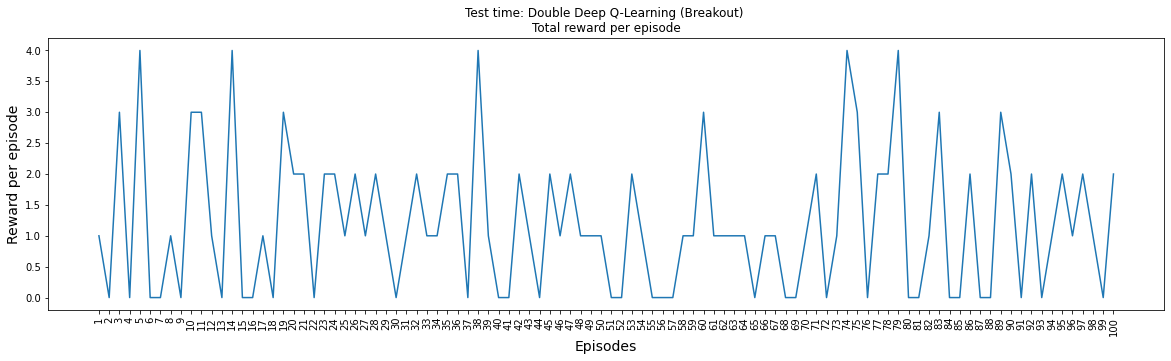

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr1)
plt.title('Test time: Double Deep Q-Learning (Breakout) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()